In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from pandas.plotting import scatter_matrix
import scipy.stats as stats
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model, pipeline, feature_extraction, ensemble, neighbors, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import string
import sys
import warnings
warnings.filterwarnings("ignore")
import pprint

In [2]:
from src.item_recommender import ItemRecommender

In [3]:
# importing the data
initial_data = pd.read_csv('data/winemag-data-130k-v2.csv')

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
initial_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [6]:
# dropping column information I do not need or want to use
new_df = initial_data.drop(['region_1', 'region_2', 'designation', 'province', 'taster_twitter_handle'], axis=1)

In [7]:
new_df['winery_variety'] = new_df['winery'] +' ' + new_df['variety']

In [8]:
new_df.head()

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery,winery_variety
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Nicosia White Blend
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Quinta dos Avidagos Portuguese Red
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Rainstorm Pinot Gris
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian,St. Julian Riesling
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks,Sweet Cheeks Pinot Noir


In [9]:
new_df.isna().sum()

Unnamed: 0            0
country              63
description           0
points                0
price              8996
taster_name       26244
title                 0
variety               1
winery                0
winery_variety        1
dtype: int64

In [10]:
new_df = new_df.drop_duplicates('description', keep='first')

In [11]:
new_df.shape

(119955, 10)

In [12]:
new_df.isna().sum()

Unnamed: 0            0
country              59
description           0
points                0
price              8388
taster_name       24912
title                 0
variety               1
winery                0
winery_variety        1
dtype: int64

In [13]:
new_df.dropna(axis=0, inplace=True)
new_df.shape

(88244, 10)

In [14]:
new_df.isna().sum()

Unnamed: 0        0
country           0
description       0
points            0
price             0
taster_name       0
title             0
variety           0
winery            0
winery_variety    0
dtype: int64

In [15]:
# country_count = new_df['country'].value_counts()

# country_count

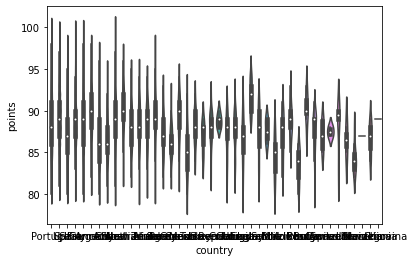

In [17]:
ax = sns.violinplot(x='country', y='points' ,data=new_df)

In [18]:
# country_count = new_df['country'].value_counts()
# country_count = country_count[:15,]
# # groups = new_df.groupby('country').filter(lambda x: len(x) >= 200).reset_index()
# plt.figure(figsize=(15,8))
# sns.boxplot(x=new_df['country'], y=new_df['points'].mean())
# plt.title('How Countries Rated Wine')
# plt.ylabel('Wine Ratings', fontsize=16)
# plt.xlabel('Country', fontsize=16)
# plt.show()

# TF IDF Recommendation

In [16]:
# Custom list of stop words

extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc', 'merlot', 'pinot', 'chardonnay','noir','cabernet','sauvignon', 'bordeaux','riesling','syrah','viognier', 'wine', 'flavors', 'fruit', 'palate','finish','aromas','notes','drink','years','good','like','nose','ripe','acidity',]
stop = set(stopwords.words('english'))
stop.update(extras)

In [17]:
# sample = new_df.sample(50000).reset_index(drop=True)
sample = new_df.head(50000)
sample.head(125)

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery,winery_variety
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Quinta dos Avidagos Portuguese Red
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Rainstorm Pinot Gris
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian,St. Julian Riesling
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks,Sweet Cheeks Pinot Noir
5,5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",87,15.0,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra),Tempranillo-Merlot,Tandem,Tandem Tempranillo-Merlot
6,6,Italy,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",87,16.0,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,Terre di Giurfo Frappato
7,7,France,"This dry and restrained wine offers spice in profusion. Balanced with acidity and a firm texture, it's very much for food.",87,24.0,Roger Voss,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,Trimbach Gewürztraminer
8,8,Germany,"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint.",87,12.0,Anna Lee C. Iijima,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhessen),Gewürztraminer,Heinz Eifel,Heinz Eifel Gewürztraminer
9,9,France,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,87,27.0,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris (Alsace),Pinot Gris,Jean-Baptiste Adam,Jean-Baptiste Adam Pinot Gris
10,10,US,"Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.",87,19.0,Virginie Boone,Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Kirkland Signature,Kirkland Signature Cabernet Sauvignon


47484


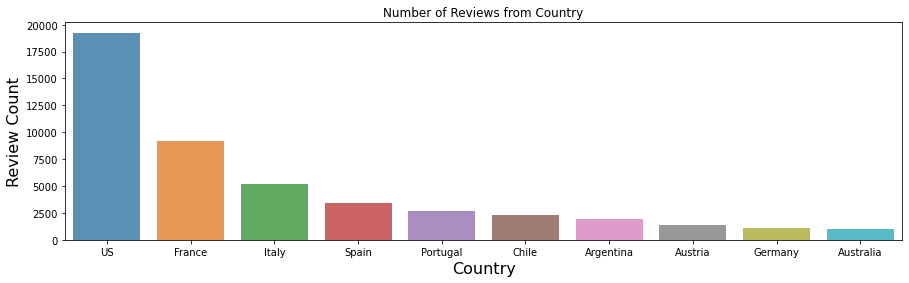

In [18]:
country_count = sample['country'].value_counts()

country_count = country_count[:10]
print(sum(country_count))
plt.figure(figsize=(15,4))
sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title('Number of Reviews from Country')
plt.ylabel('Review Count', fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.show()

In [19]:
sample['points'].describe()

count    50000.000000
mean        88.540140
std          2.971761
min         80.000000
25%         86.000000
50%         88.000000
75%         91.000000
max        100.000000
Name: points, dtype: float64

Text(0.5, 1.0, 'Length of Wine Reviews')

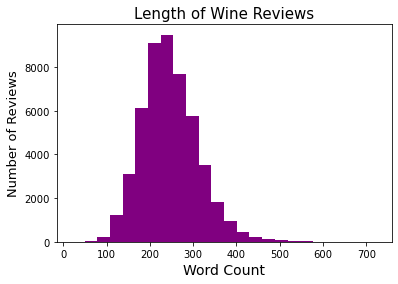

In [45]:
plt.hist([len(i) for i in sample['description']], 24, facecolor='purple')
plt.xlabel(' Count', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=13)
plt.title('Length of Wine Reviews', fontsize=15)

In [22]:
variety_count = sample['variety'].value_counts()

len(variety_count)

565

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# Instantiate the tf idf vectorizer
tf = TfidfVectorizer(stop_words=stop, ngram_range=(1,2), max_df=.2)

# Put the wine descriptions through the vectorizer and create tf idf matrix
tfidf_matrix = tf.fit_transform(sample.description)


tfidf_cosine_similarity = cosine_similarity(tfidf_matrix)


In [24]:
tfidf_matrix.shape

(50000, 473410)

In [25]:
wine_recommender = ItemRecommender()
wine_recommender.fit(tfidf_matrix, sample.title)

In [26]:
print(wine_recommender.get_recommendations('Hindsight 2013 Bella Vetta Vineyard Cabernet Sauvignon (Howell Mountain)'))

['Kuleto Estate 2013 Cabernet Sauvignon (Napa Valley)'
 'Proulx 2012 Pinot Noir (Central Coast)'
 'Davis Family 2012 Horseshoe Bend Vineyard Pinot Noir (Russian River Valley)'
 'Davies 2013 Red Cap Vineyard Cabernet Sauvignon (Howell Mountain)'
 "Ghost Pines 2015 Winemaker's Reserve Zinfandel (Sonoma County-San Joaquin County)"]


# SKLearn LDA 

In [46]:
n_components = 10
lda = LatentDirichletAllocation(n_components)
topic_values = lda.fit_transform(tfidf_matrix)

In [47]:
lda.components_.shape

(10, 473410)

In [48]:
wine_recommender = ItemRecommender()
wine_recommender.fit(topic_values, sample.title)

In [49]:
print(wine_recommender.get_recommendations('Hindsight 2013 Bella Vetta Vineyard Cabernet Sauvignon (Howell Mountain)'))

['Nickel & Nickel 2012 State Ranch Cabernet Sauvignon (Yountville)'
 'Creekside Cellars 2012 Franc Cabernet Franc (Grand Valley)'
 'Adelsheim 2009 Ribbon Springs Vineyard Auxerrois (Ribbon Ridge)'
 'Bravium 2011 Signal Ridge Vineyard Dragonfly Block Pinot Noir (Mendocino Ridge)'
 'Mansfield-Dunne 2013 Pinot Noir (Santa Lucia Highlands)']


In [50]:
vocab = tf.get_feature_names()

n_top_words = 10
n_topics = n_components

topic_words = {}

for topic, comp in enumerate(lda.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    
    topic_words[topic] = [vocab[i] for i in word_idx]

In [51]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
display_topics(lda, vocab, num_top_words)

Topic 0:
black full fruits texture rich crisp fresh citrus apple spice
Topic 1:
fruits fresh black soft light plum rich full oak berry
Topic 2:
black full fresh fruits rich light texture dry apple spice
Topic 3:
dry light fresh black full spice well rich plum texture
Topic 4:
black offers alongside black cherry spice berry note opens pepper plum
Topic 5:
full black fresh plum berry apple dry rich light well
Topic 6:
black fresh apple full berry fruits light rich plum spice
Topic 7:
black light berry texture fruits rich well full plum spice
Topic 8:
fruits black fresh berry soft light rich spice full crisp
Topic 9:
full fresh black light apple fruits crisp berry rich well


In [54]:
n_components_2 = 20
lda_2 = LatentDirichletAllocation(n_components_2)
topic_values_2 = lda_2.fit_transform(tfidf_matrix)

KeyboardInterrupt: 

In [ ]:
lda_2.components_.shape

In [ ]:
wine_recommender_2 = ItemRecommender()
wine_recommender_2.fit(topic_values_2, sample.title)

In [ ]:
vocab_2 = tf.get_feature_names()

n_top_words = 10
n_topics_2 = n_components_2

topic_words_2 = {}

for topic, comp in enumerate(lda_2.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    
    topic_words[topic] = [vocab[i] for i in word_idx]

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
display_topics(lda_2, vocab_2, num_top_words)



In [ ]:
topics_df = pd.DataFrame(topic_values)

In [ ]:
data_with_topics = sample.join(topics_df)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data_with_topics[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]
x_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities_lda = cosine_similarity(x_scaled)

In [ ]:
lda_wine_recommender = ItemRecommender()
lda_wine_recommender.fit(tfidf_matrix, sample.title)

In [ ]:
x_scaled[4]

# LDA Topic Modeling with Gensim

In [ ]:
import nltk; nltk.download('stopwords')
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc', 'merlot', 'pinot', 
        'chardonnay','noir','cabernet','sauvignon', 'bordeaux','riesling','syrah','viognier',
        'wine', 'flavors', 'fruit', 'palate','finish','aromas','notes','drink','years','good',
        'like','nose','ripe','acidity',]
stop_words = stopwords.words('english')
stop_words.extend(extras)

In [ ]:
# convert the wine reviews into list
data = sample.description.values.tolist()

pprint(data[:1])

In [ ]:
# gensim's simple_preprocess is used to toeknize each sentence into a list of words, removing puncutation,
# and unenecessary characters

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

In [ ]:
# Create bigrams and trigrams


bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[data_words[0]])

In [ ]:
# User input wine features for recommendation
user_input = ['this would be a paragraph of a users wine preferences. ']

# Run the user input through tf idf vectorizer 
user_tf_vec = TfidfVectorizer()
user_tf_vec.fit(#wine reviews)

user_vector = user_tf_vec.transform(user_input)

#create tf idf matrix using transform
user_tfidf_matrix = user_tf_vec.transform(user_input)

#create cosine similarity
user_cosine_similarity = cosine_similarity(user_tfidf_matrix)

In [ ]:
# text description from user as input for recommender
# use tf idf transform the user's input into a vectorizer and apply cosine similarity 
# sort after this with cosine

In [ ]:
user_tfidf_matrix.shape
